In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)


engine.dispose()

In [2]:
housing_df.head(15)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [3]:
#Overview of columns
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
#Missing values
missing_values_count = housing_df.isnull().sum().sort_values(ascending=False)
missing_values_count

poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
                 ... 
centralair          0
salecondition       0
heating             0
totalbsmtsf         0
id                  0
Length: 81, dtype: int64

In [6]:
#Percentage of missing values
missing_values_percent = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_values_percent

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
                   ...   
centralair       0.000000
salecondition    0.000000
heating          0.000000
totalbsmtsf      0.000000
id               0.000000
Length: 81, dtype: float64

In [7]:
#Combine both count and percentage of missing values into a table
missing_values = pd.concat([missing_values_count, missing_values_percent], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Of the 79 variables, 19 variables have missing values.  After going through each variable and understanding what it represents, I have decided that none of these variables will become features in the model.  There are simply more relevant variables to predict our target variable.  Therefore, I don't need to determine how to fill in the missing values for any of the 19 variables missing data, and they will be removed from the dataframe.  

In [8]:
#Dropping 19 columns with missing values
housing_df.drop(['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'lotfrontage', 'garagecond', 'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'bsmtexposure', 'bsmtfintype2',
                            'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrtype', 'masvnrarea', 'electrical'], axis=1, inplace=True)
housing_df.columns.nunique()

62

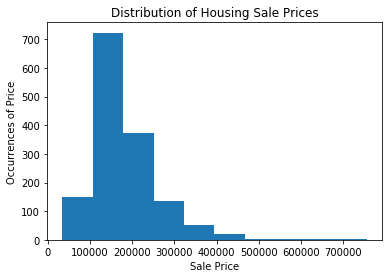

In [9]:
#Exploratory analysis
#Histogram of target variable - sale price
plt.hist(housing_df.saleprice)
plt.xlabel('Sale Price')
plt.ylabel('Occurrences of Price')
plt.title('Distribution of Housing Sale Prices')

plt.show()

The sale price has a skewed distribution.  As there is are higher occurrences of lower sales price and less occurrences of larger sale prices, the distribution is skewed right.  

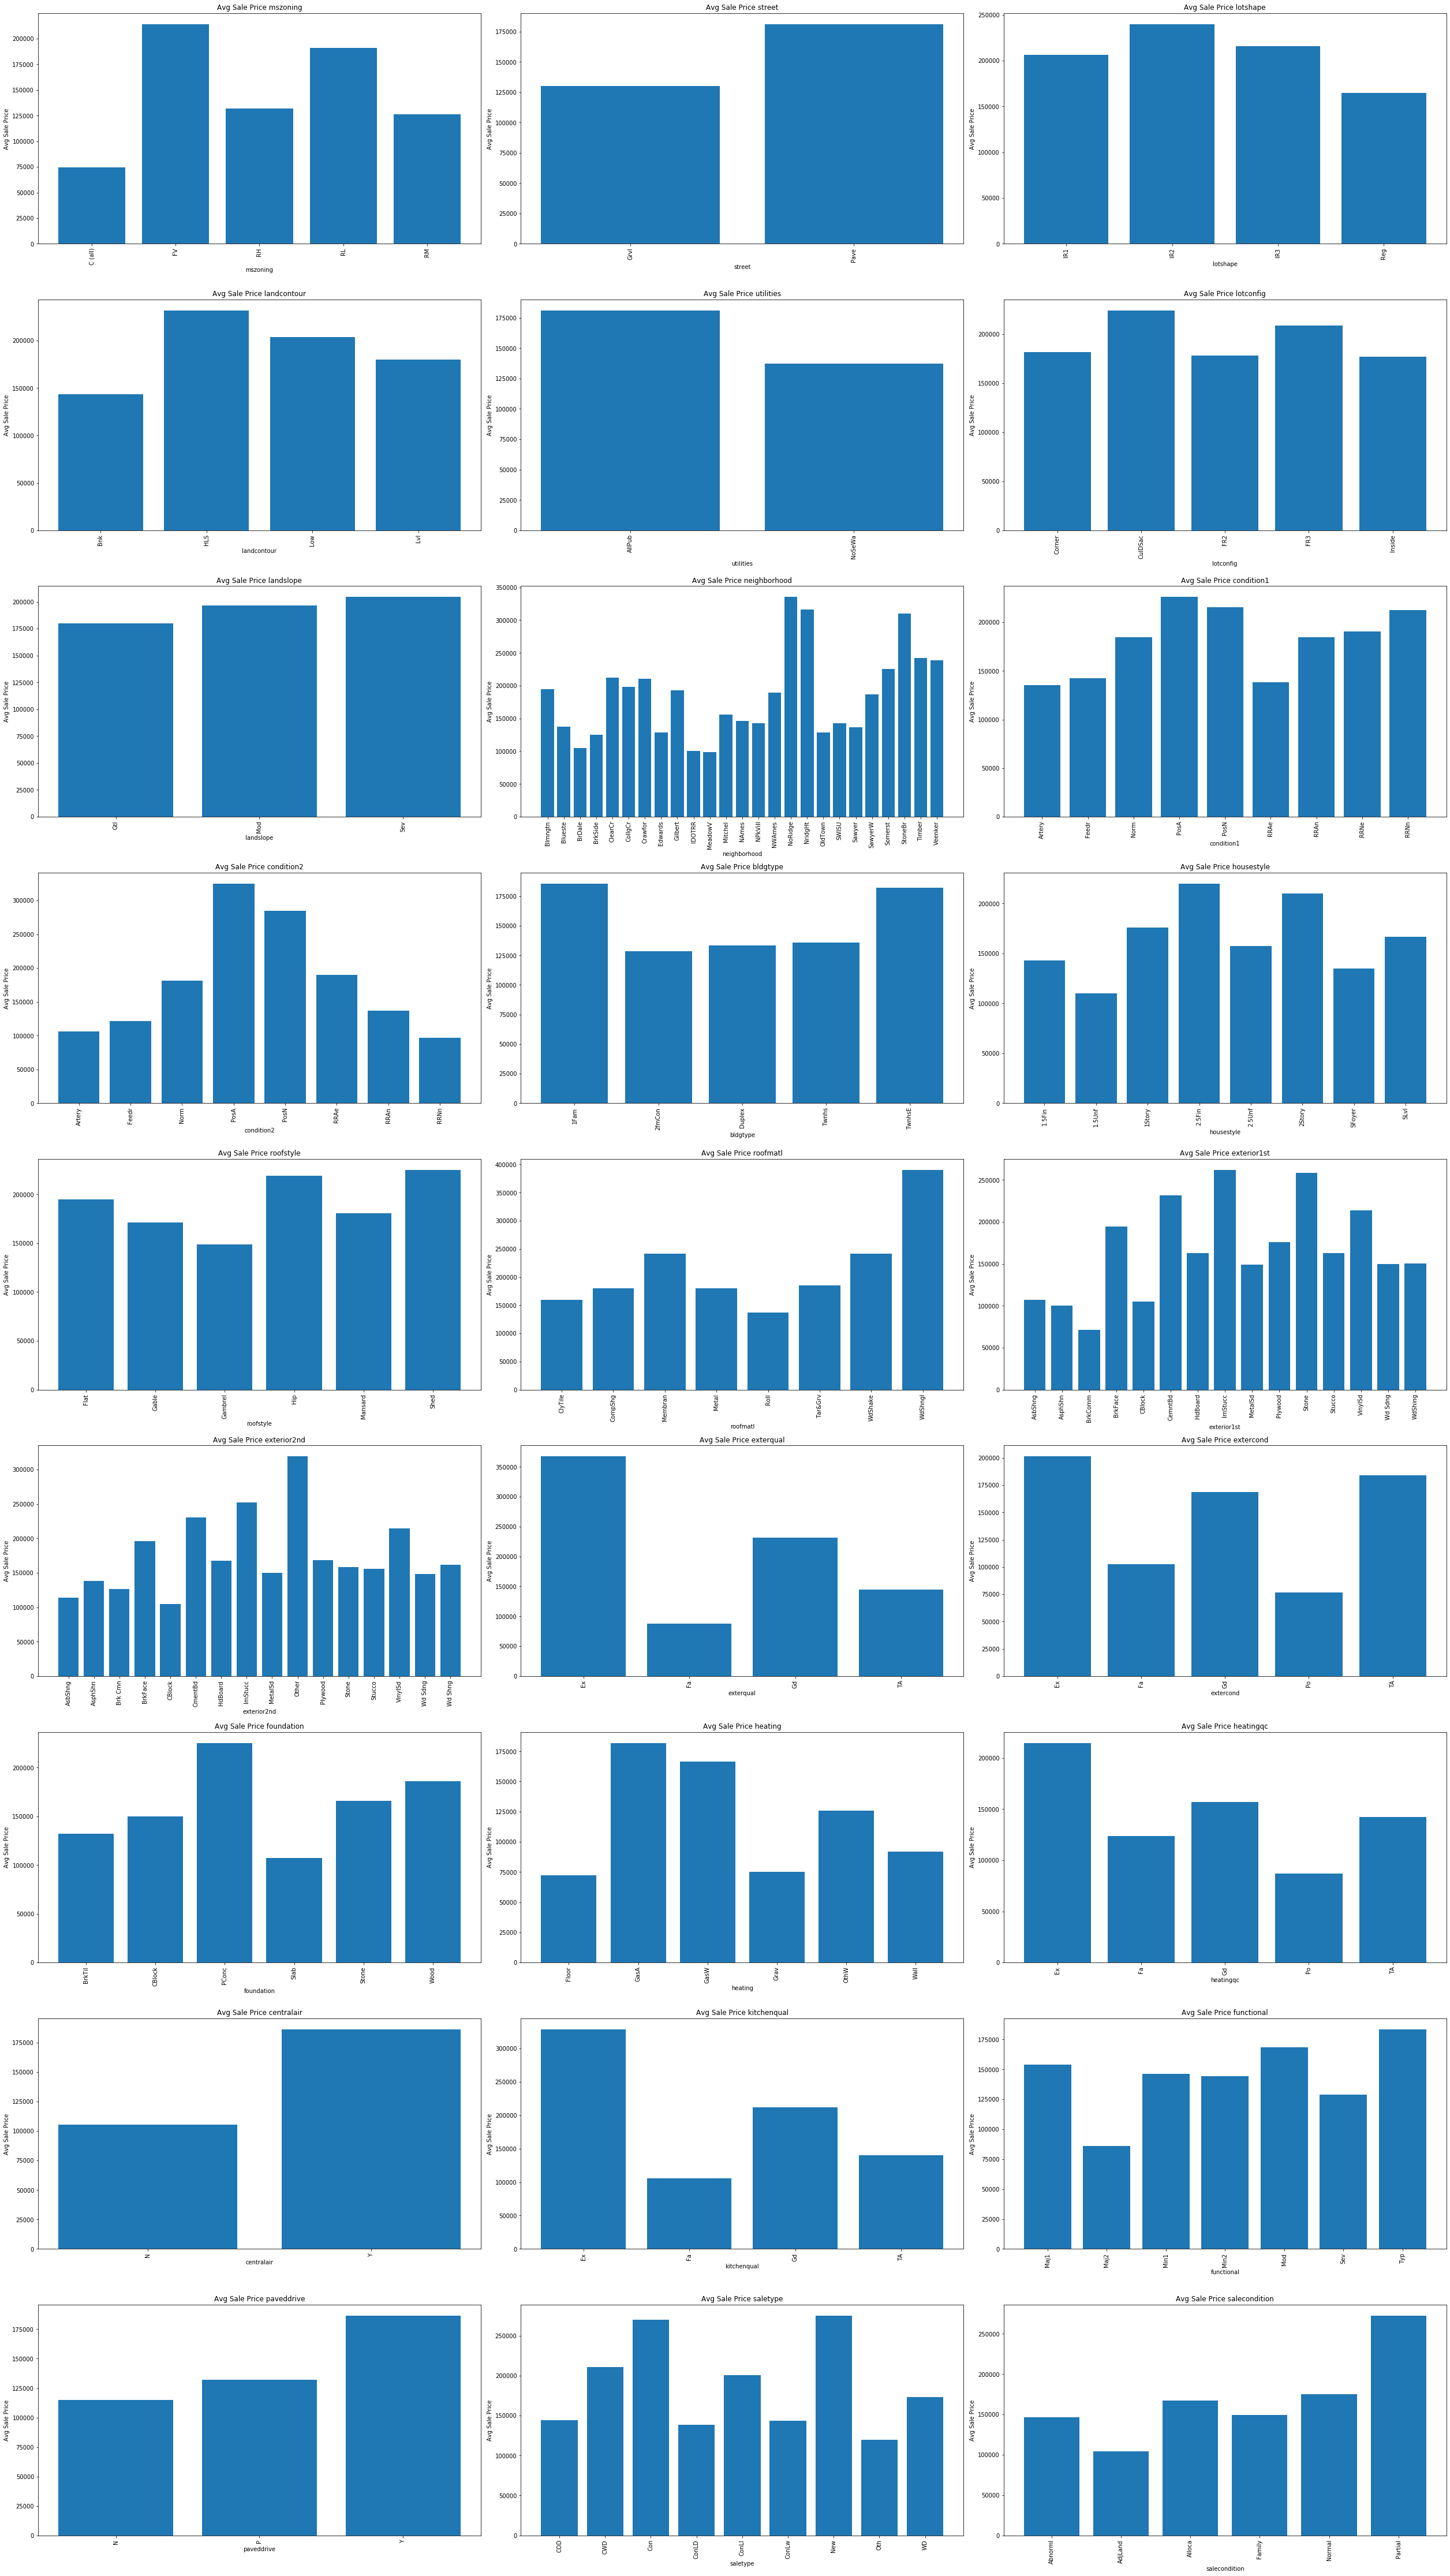

In [10]:
#Bar plots show the relationship between sale price (target variable) and categorical variables

categorical_variables = housing_df.select_dtypes(['object']).columns

plt.figure(figsize=(35, 75))
for i, col in enumerate(categorical_variables):
    plt.subplot(11,3,i+1)
    plt.bar(housing_df.groupby(col)['saleprice'].mean().index, housing_df.groupby(col)['saleprice'].mean())
    plt.title('Avg Sale Price ' + categorical_variables[i])
    plt.ylabel('Avg Sale Price')
    plt.xlabel(col)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [11]:
#Correlations of variables
continuous_variables = housing_df.select_dtypes(['int64', 'float64']).columns

housing_df[continuous_variables].corr()

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.005024,-0.005968,-0.007940,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotarea,-0.033226,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.046231,0.040229,-0.136841,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.128451,-0.067759,0.181133,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
bsmtfinsf1,-0.005024,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,1.000000,-0.050117,-0.495251,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
bsmtfinsf2,-0.005968,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.050117,1.000000,-0.209294,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
bsmtunfsf,-0.007940,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,-0.495251,-0.209294,1.000000,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479


In [12]:
#Correlation between target variable and continuous variable
(housing_df[continuous_variables].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64

After looking at the exploratory analysis, I'm going to choose 39 features total - 6 continuous, 31 categorical, and 2 interaction terms. <br>

The continuous variables will be overallqual (Overall Quality - overall building and material quality), grlivearea (GrLivArea - above grade (ground) living area square feet), garagecars(Garage Cars - size of garage in car capacity), garagearea, totalbsmtsf, firstflrsf, and secondflrsf. Interaction terms of overall quality and year built, as well overall quality and square footage of the basement, first floor, and second floor are included.  <br>

The categorical variables will be neighborhood, exterqual(Exterior material quality), and mszoning because those features show variability. Breaking them up into dummy variables creates 31 different features.   

In [13]:
#Create dummies for the categorical features
housing_df = pd.get_dummies(housing_df, columns=['exterqual', 'neighborhood', 'mszoning'], drop_first=True)

In [14]:
#Creating variable for all dummy columns
dummy_columns = ['exterqual_Fa', 'exterqual_Gd','exterqual_TA', 'neighborhood_Blueste',
'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards',
'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV',
'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill',
'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer',
'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr',
'neighborhood_Timber', 'neighborhood_Veenker', 'mszoning_FV',
'mszoning_RH', 'mszoning_RL', 'mszoning_RM']

In [15]:
#Create interaction terms
housing_df['interaction_overallqual_sf'] = housing_df.overallqual * (housing_df.totalbsmtsf + housing_df.firstflrsf + housing_df.secondflrsf)
housing_df['interaction_overallqual_yrbuilt'] = housing_df.overallqual * housing_df.yearbuilt


In [16]:
#Setting variables for model
X = housing_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 
                'interaction_overallqual_yrbuilt', 'interaction_overallqual_sf'] + dummy_columns]
Y = housing_df.saleprice

In [17]:
#Splitting data into train/test sets and setting alpha levels (lambda)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 1168
The number of observations in test set is 292


In [18]:
#OLS

lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8181459984370967
-----Test set statistics-----
R-squared of the model in the test set is: 0.8411188385155551
Mean absolute error of the prediction is: 21412.253035821843
Mean squared error of the prediction is: 1058218252.8801483
Root mean squared error of the prediction is: 32530.266720089283
Mean absolute percentage error of the prediction is: 12.250565198691652


In [19]:
#Ridge

ridgeregr = RidgeCV(alphas=alphas, cv=5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8181459984370968
-----Test set statistics-----
R-squared of the model on the test set is: 0.8411188385155021
Mean absolute error of the prediction is: 21412.253035827165
Mean squared error of the prediction is: 1058218252.8805015
Root mean squared error of the prediction is: 32530.26672009471
Mean absolute percentage error of the prediction is: 12.250565198689472


In [20]:
#Lasso

lassoregr = LassoCV(alphas=alphas, cv=5)
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8179106550912866
-----Test set statistics-----
R-squared of the model on the test set is: 0.8395756218723269
Mean absolute error of the prediction is: 21474.031005237488
Mean squared error of the prediction is: 1068496752.8908142
Root mean squared error of the prediction is: 32687.868588985948
Mean absolute percentage error of the prediction is: 12.276575878749577


In [21]:
#ElasticNet

elasticregr = ElasticNetCV(alphas=alphas, cv=5)
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8178992392165062
-----Test set statistics-----
R-squared of the model on the test set is: 0.8396205701962578
Mean absolute error of the prediction is: 21475.25364214349
Mean squared error of the prediction is: 1068197377.3300138
Root mean squared error of the prediction is: 32683.28896133334
Mean absolute percentage error of the prediction is: 12.276184047212856


#### Evaluting the tests

##### OLS Model
R-squared of the model in the training set is: 0.8181459984370967 <br>
-----Test set statistics-----  <br>
R-squared of the model in the test set is: 0.8411188385155551 <br>
Mean absolute error of the prediction is: 21412.253035821843 <br>
Mean squared error of the prediction is: 1058218252.8801483 <br>
Root mean squared error of the prediction is: 32530.266720089283 <br>
Mean absolute percentage error of the prediction is: 12.250565198691652 <br> <br>

##### Ridge Model
R-squared of the model on the training set is: 0.8181459984370968 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8411188385155021 <br>
Mean absolute error of the prediction is: 21412.253035827165  <br>
Mean squared error of the prediction is: 1058218252.8805015 <br>
Root mean squared error of the prediction is: 32530.26672009471 <br>
Mean absolute percentage error of the prediction is: 12.250565198689472 <br>

##### Lasso Model
R-squared of the model on the training set is: 0.8179106550912866 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8395756218723269 <br>
Mean absolute error of the prediction is: 21474.031005237488 <br>
Mean squared error of the prediction is: 1068496752.8908142 <br>
Root mean squared error of the prediction is: 32687.868588985948 <br>
Mean absolute percentage error of the prediction is: 12.276575878749577 <br>

##### ElasticNet Model
R-squared of the model on the training set is: 0.8178992392165062 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8396205701962578 <br>
Mean absolute error of the prediction is: 21475.25364214349 <br>
Mean squared error of the prediction is: 1068197377.3300138 <br>
Root mean squared error of the prediction is: 32683.28896133334 <br>
Mean absolute percentage error of the prediction is: 12.276184047212856 <br> <br>

The OLS and Ridge models are the best.  They both are very similar in their evaluation metrics.  The R-squared values for both the training and test sets have neglible differences (approx. 0.0000000000000001 and 0.0000000000000530 differences in R-squared, respectively).  The error evaluation metrics reflect the same neglible differences.